In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# Print Fields in the Table of the Database
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(f'{c["name"]}      \t{c["type"]}')

id      	INTEGER
station      	TEXT
date      	TEXT
prcp      	FLOAT
tobs      	FLOAT


In [11]:
# Print Fields in the Table of the Database
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(f'{c["name"]}      \t{c["type"]}')

id      	INTEGER
station      	TEXT
name      	TEXT
latitude      	FLOAT
longitude      	FLOAT
elevation      	FLOAT


# Exploratory Climate Analysis

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data


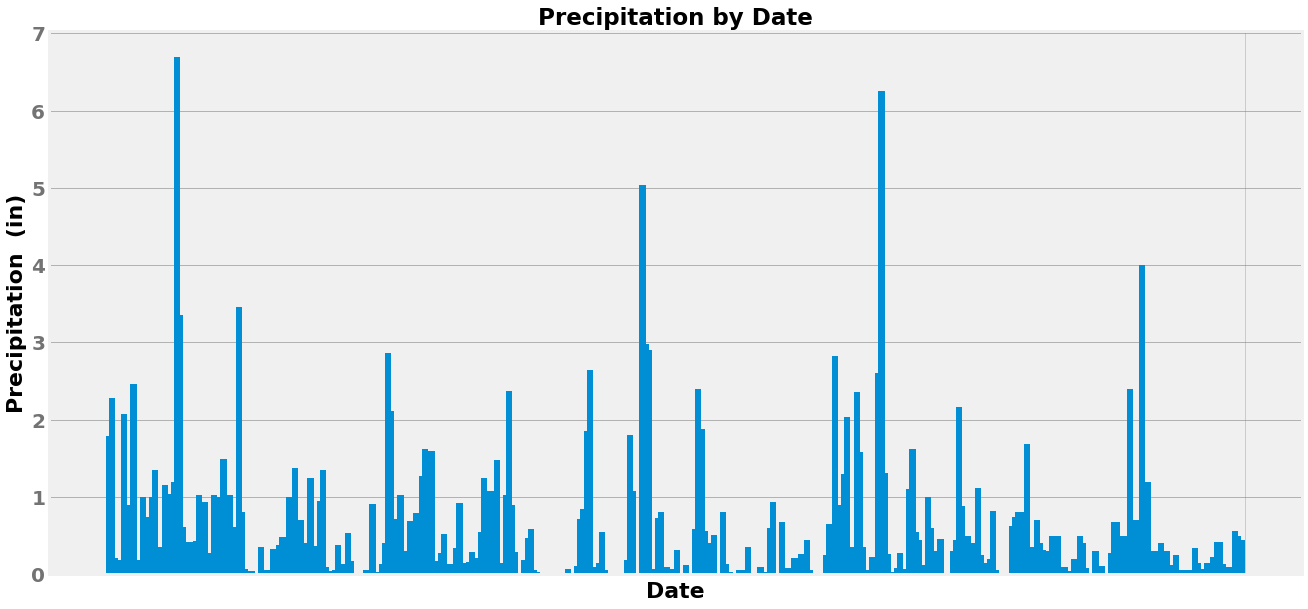

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results


precipitation = session.query(Measurement.date,Measurement.prcp).\
                    filter(func.strftime("%Y-%m-%d", Measurement.date) >= '2016-08-23').\
                    order_by(Measurement.date).all()

# Load data to a dataframe
precipitation_df = pd.DataFrame(precipitation, columns=['Date', 'Precipitation'])
# Sort dataframe by date
precipitation_df = precipitation_df.sort_values(by='Date', ascending=True)
#precipitation_df = precipitation_df.dropna()

# For setting up the index
# precipitation_df.set_index('Date', inplace=True)

# Resize the plot
plt.figure(figsize=(20,10));

# Plot the precipitation
plt.bar(precipitation_df["Date"], precipitation_df["Precipitation"], 
        align='center', width=2);

# Define the reference font size
ref_font_size = 20

# Add labels and Title
plt.xlabel('Date',fontweight="bold", fontsize=ref_font_size+2);
plt.ylabel('Precipitation  (in)',fontweight="bold", fontsize=ref_font_size+2);
plt.title('Precipitation by Date' ,fontweight="bold", fontsize=ref_font_size+3);

# Add Grids
plt.grid(b=bool, which='major', axis='y', color='grey',  alpha=0.55);

# Add ticks
plt.xticks("", rotation=90, fontweight="bold", alpha=0.55);
plt.yticks(rotation=0, fontweight="bold", alpha=0.55, fontsize=ref_font_size);

# Save Plot
plt.savefig("Output/Fig 1. Barchart - Precipitation by Date" +'.png',bbox_inches='tight');

#Show the Plot
plt.show();

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
# precipitation_df.set_index('Date', inplace=True)
precipitation_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [15]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.id)).all()

[(9)]

In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Station.station, func.count(Station.id)).\
    filter(Station.station == Measurement.station).\
    group_by(Measurement.station).\
    order_by(func.count(Station.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(Measurement.station,  func.min(Measurement.tobs), 
              func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == "USC00519281").\
    group_by(Measurement.station).all()

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

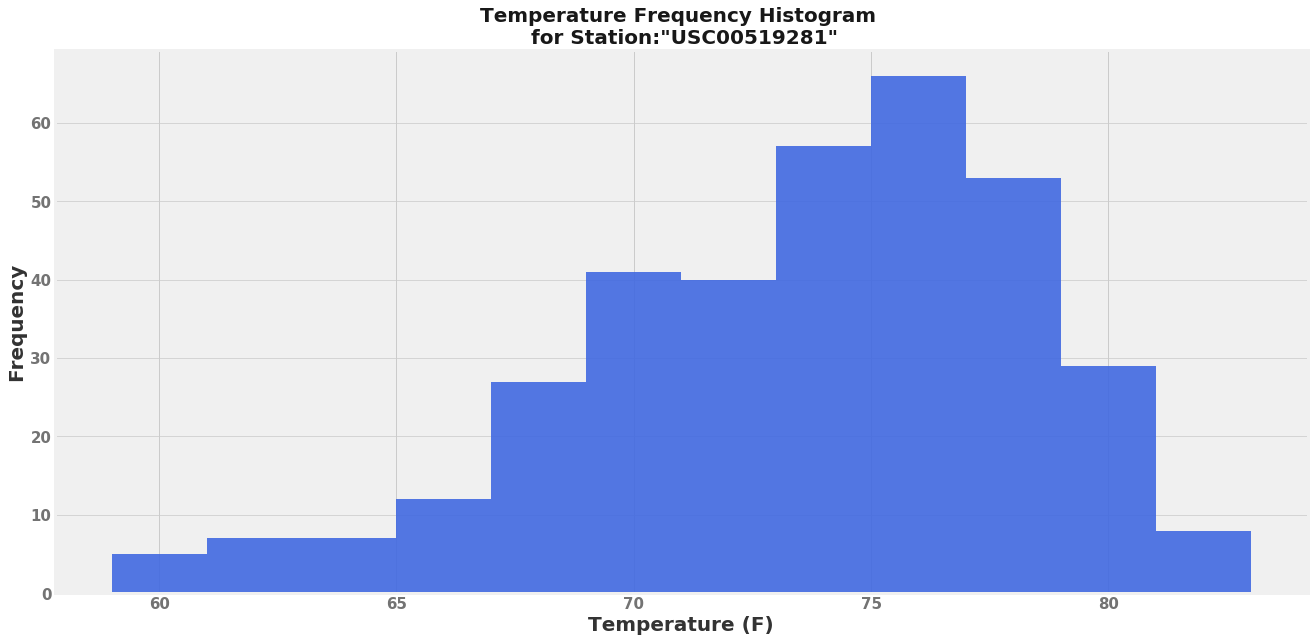

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature = session.query(Measurement.date,  Measurement.tobs).\
                    filter(Measurement.station == "USC00519281").\
                    filter(func.strftime("%Y-%m-%d", Measurement.date) >= '2016-08-23').all()

# Temperature dataframe cleanning process
temperature_df = pd.DataFrame(temperature, columns=['Date', 'Temperature'])
temperature_df = temperature_df.sort_values(by='Date', ascending=True)
temperature_df.set_index('Date', inplace=True)

# Resize Plot
plt.figure(figsize=[20,10]);

# Define Histogram paramaters
n, bins, patches = plt.hist(x=temperature_df["Temperature"], bins=12, 
                           color='royalblue',alpha=0.9);
# Labeling, tickers and grids
plt.grid(axis='y', alpha=0.75);
plt.xlabel('Temperature (F)',fontweight="bold", alpha=0.8, fontsize=20);
plt.ylabel('Frequency',fontweight="bold", alpha=0.8, fontsize=20);
plt.xticks(fontsize=15, fontweight="bold", alpha=0.55);
plt.yticks(fontsize=15, fontweight="bold", alpha=0.55);
plt.title('Temperature Frequency Histogram \n for Station:"USC00519281"',
          fontweight="bold", alpha=0.9, fontsize=20);

# Save Plot
plt.savefig("Output/Fig 2. Histogram - Temperature Frequency for Station USC00519281" +'.png',bbox_inches='tight');

#Show the Plot
plt.show();

In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [20]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
# Vacation Dates
initial_vacation_date = "2016-12-01"
final_vacation_date = "2016-12-16"

# Previous Year Dates
initial_prevyear_date = "2015-12-01"
final_prevyear_date = "2015-12-16"

# Max, min and average calculation
min_vacation_temp = calc_temps(initial_prevyear_date, final_prevyear_date)[0][0]
avg_vacation_temp = calc_temps(initial_prevyear_date, final_prevyear_date)[0][1]
max_vacation_temp = calc_temps(initial_prevyear_date, final_prevyear_date)[0][2]

print(min_vacation_temp, avg_vacation_temp, max_vacation_temp)

65.0 73.41836734693878 82.0


## Temperature Analysis II

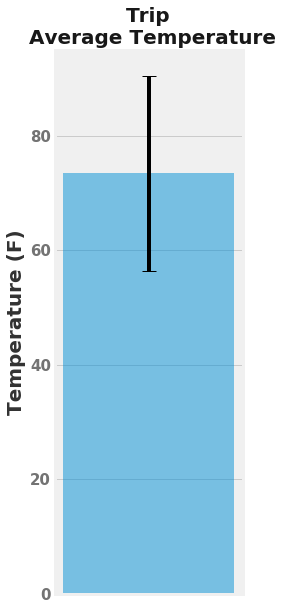

In [21]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

error_prev_year = max_vacation_temp-min_vacation_temp

# Resize Plot
plt.figure(figsize=[3,10]);

# Define Bar and Error paramaters
plt.bar(1, avg_vacation_temp, yerr=error_prev_year, align='center', alpha=0.5, 
        ecolor='black', capsize=7)

# Labeling, tickers and grids

plt.ylabel('Temperature (F)',fontweight="bold", alpha=0.8, fontsize=20);
plt.xticks(fontsize=15, fontweight="bold", alpha=0.55);
plt.yticks(fontsize=15, fontweight="bold", alpha=0.55);
plt.title('Trip\n Average Temperature',
          fontweight="bold", alpha=0.9, fontsize=20);
plt.grid(b=None, which='major', axis='x')

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

# Save Plot
plt.savefig("Output/Fig 3. Barchart - Trip Average Temperature" +'.png',bbox_inches='tight');

#Show the Plot
plt.show();

In [22]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
session.query(Station.station,  Station.name, Station.latitude, Station.longitude, Station.elevation).\
   filter(Station.station == Measurement.station).\
       filter(Measurement.date >= initial_prevyear_date).filter(Measurement.date <= final_prevyear_date).\
           group_by(Measurement.station).\
               order_by(Measurement.prcp.desc()).all()


[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)]

## Optional Challenge Assignment

In [23]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")[0]

(62.0, 69.15384615384616, 77.0)

In [24]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

from datetime import timedelta  

# Vacation Dates
initial_vacation_date = dt.date(2016,12,1)
final_vacation_date = dt.date(2016,12,16) 

# Initialize variables for while loop
date_while = initial_vacation_date 
vacation_dates = [date_while]

# Create a list with all the dates within the vacation range
while date_while < final_vacation_date:
    date_while += timedelta(days=1)
    vacation_dates.append(date_while)

# Calculate the normals in the list of vacation dates using the  %m-%d strings
normals = []
dates_normal = []
for date_for in vacation_dates:
    date_no_year = date_for.strftime('%m') + "-" + date_for.strftime('%d')
    normals.append(daily_normals(date_no_year)[0])
    dates_normal.append(date_no_year)

# Print the results
normals

[(65.0, 71.91666666666667, 78.0),
 (62.0, 71.32692307692308, 77.0),
 (67.0, 72.88679245283019, 79.0),
 (66.0, 72.17647058823529, 81.0),
 (64.0, 70.92156862745098, 78.0),
 (61.0, 69.3921568627451, 78.0),
 (58.0, 69.2, 79.0),
 (60.0, 70.27450980392157, 83.0),
 (64.0, 71.90196078431373, 80.0),
 (61.0, 71.24528301886792, 78.0),
 (64.0, 72.38775510204081, 78.0),
 (64.0, 70.88235294117646, 79.0),
 (65.0, 70.9423076923077, 80.0),
 (65.0, 71.18, 78.0),
 (62.0, 71.34, 79.0),
 (60.0, 69.62264150943396, 82.0)]

In [25]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, index=vacation_dates, columns = ['T Min' , 'T Avg', 'T Max']) 
normals_df.index.name = "Vacation Date"
normals_df

,T Min,T Avg,T Max
Vacation Date,,,
2016-12-01,65.0,71.916667,78.0
2016-12-02,62.0,71.326923,77.0
2016-12-03,67.0,72.886792,79.0
2016-12-04,66.0,72.176471,81.0
2016-12-05,64.0,70.921569,78.0
2016-12-06,61.0,69.392157,78.0
2016-12-07,58.0,69.200000,79.0
2016-12-08,60.0,70.274510,83.0
2016-12-09,64.0,71.901961,80.0


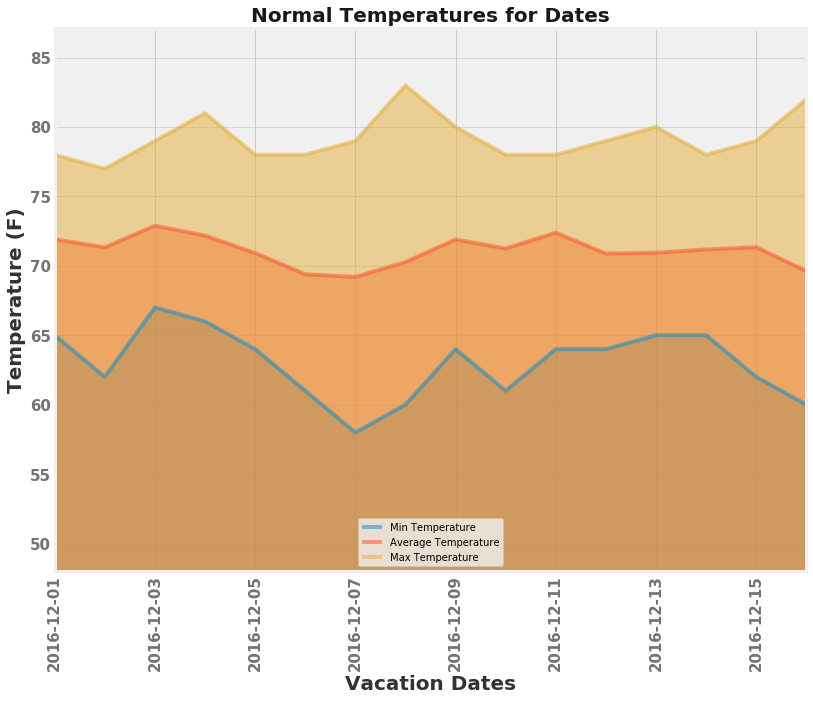

In [26]:
# Plot the daily normals as an area plot with `stacked=False`

# Plot
normals_df.plot.area(stacked=False, figsize=(12, 10))

# Legend
plt.legend(('Min Temperature', 'Average Temperature', 'Max Temperature'),loc='lower center')

# Labeling, tickers and grids
plt.grid(axis='y', alpha=0.75);
plt.xlabel('Vacation Dates',fontweight="bold", alpha=0.8, fontsize=20);
plt.ylabel('Temperature (F)',fontweight="bold", alpha=0.8, fontsize=20);
plt.xticks(fontsize=15, fontweight="bold", alpha=0.55, rotation=90);
plt.yticks(fontsize=15, fontweight="bold", alpha=0.55);
plt.title('Normal Temperatures for Dates',
          fontweight="bold", alpha=0.9, fontsize=20);
plt.ylim(bottom=min(normals_df["T Min"])-10)  
# Save Plot
plt.savefig("Output/Fig 4. Area Plot - Normal Temperatures for Vacation Dates" +'.png',
            bbox_inches='tight');

#Show the Plot
plt.show();


## Temperature Analysis I

### Temperature June

In [27]:
temp_june = session.query(Measurement.date, Measurement.tobs).\
                    filter(func.strftime("%m", Measurement.date) == '06').\
                    order_by(Measurement.date).all()

# Load data to a dataframe
temp_june_df = pd.DataFrame(temp_june, columns=['Date', 'Temperature'])
# Sort dataframe by date
temp_june_df = temp_june_df.sort_values(by='Date', ascending=True)
# Set date as index
temp_june_df.set_index('Date', inplace=True)
temp_june_df.describe()

,Temperature
count,1700.000000
mean,74.944118
std,3.257417
min,64.000000
25%,73.000000
50%,75.000000
75%,77.000000
max,85.000000


### Temperature December

In [28]:
temp_dec = session.query(Measurement.date, Measurement.tobs).\
                    filter(func.strftime("%m", Measurement.date) == '12').\
                    order_by(Measurement.date).all()

# Load data to a dataframe
temp_dec_df = pd.DataFrame(temp_dec, columns=['Date', 'Temperature'])
# Sort dataframe by date
temp_dec_df = temp_dec_df.sort_values(by='Date', ascending=True)
# Set date as index
temp_dec_df.set_index('Date', inplace=True)
temp_dec_df.describe()

,Temperature
count,1517.000000
mean,71.041529
std,3.745920
min,56.000000
25%,69.000000
50%,71.000000
75%,74.000000
max,83.000000


### T-test

In [29]:
from scipy import stats
t_test_ind = stats.ttest_ind(temp_june_df, temp_dec_df, equal_var=False)
t_test_ind

Ttest_indResult(statistic=array([31.35503692]), pvalue=array([4.19352984e-187]))

In [30]:
p = t_test_ind[1]
alpha = 0.05

# interpret via p-value
if p > alpha:
    print('Accept null hypothesis that the means are equal.\
        \nThe difference in means is NOT statistically significant')
else:
    print('Reject the null hypothesis that the means are equal.\
          \nThe difference in means is statistically significant')

Reject the null hypothesis that the means are equal.          
The difference in means is statistically significant


## Analysis
- The used test is the independent test because the means of the months do not 
depend on each other. The temperature measurements are not necessaryly exactly in the same stations along the years.
- Reject the null hypothesis that the means are equal.
- The difference in means is statistically significant
